# import Library

In [1]:
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
from enum import Enum
import pandas as pd
import time
from collections import defaultdict
from collections import namedtuple
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import os
import io
import re
from collections import namedtuple
from collections import deque
import tensorflow as tf
from tensorflow.python import keras as K
from PIL import Image
import matplotlib.pyplot as plt
import random
# from mylibrary.fnframework import FNAgent,Environment,Action,Trainer
from mylibrary.plottrade import PlotTrade
from mylibrary.maketraindata import MakeTrainData
import xgboost as xgb
from sklearn.metrics import accuracy_score  
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from tensorflow.python.keras.models import load_model
import statsmodels.graphics.api as smg
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
from scipy.stats import f
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report, accuracy_score,roc_curve, roc_auc_score
import pickle
import datetime

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [1]:
li = ['a','b','c']
name = ''
for i in li:
    name+=i
print(name)

abc


# path ubu

In [11]:
path_daw = '/home/hipro/デスクトップ/StockPriceData/Stock_index/DAW_10years.csv'
path_tpx = '/home/hipro/デスクトップ/StockPriceData/Stock_index/TOPIX_10years.csv'


# path mac

In [2]:
path_tpx = '/Users/rince/Desktop/StockPriceData/Stock_index/TOPIX_10years.csv'
path_225 = '/Users/rince/Desktop/StockPriceData/Stock_index/NK225_10years.csv'
path_daw = '/Users/rince/Desktop/StockPriceData/Stock_index/DAW_10years.csv'
path_bear = '/Users/rince/Desktop/StockPriceData/Stock_index/R225BEAR_10years.csv'

# funcs

In [3]:
def xgb_pred(x_train, y_train, x_test, y_test):
    param_dist = {'objective':'binary:logistic', 'n_estimators':16,'use_label_encoder':False,
                 'max_depth':4}
    param_def = {'objective':'binary:logistic','use_label_encoder':False}
    xgb_model = xgb.XGBClassifier(**param_dist)
    hr_pred = xgb_model.fit(x_train.astype(float), np.array(y_train), eval_metric='logloss').predict(x_test.astype(float))
    print("---------------------")
    y_proba_train = xgb_model.predict_proba(x_train)[:,1]
    y_proba = xgb_model.predict_proba(x_test)[:,1]
    print('AUC train:',roc_auc_score(y_train,y_proba_train))    
    print('AUC test :',roc_auc_score(y_test,y_proba))
    print(classification_report(np.array(y_test), hr_pred))
    xgb.plot_importance(xgb_model) 
    return xgb_model

def for_xgb_data(path_tpx, path_daw):
    df_tpx = DataFramePreProcessing(path_tpx).load_df()
    df_daw = DataFramePreProcessing(path_daw,is_daw=True).load_df()
    daw_p = df_daw.pct_change()
    df_con = pd.concat([daw_p,df_tpx],axis = 1,join='inner').astype(float)
    df_tmp = df_con.drop(df_con[ df_con['volume']==0].index)
    return df_tmp

def make_x_train(path_tpx, path_daw):
    df_tpx  = DataFramePreProcessing(path_tpx).load_df()
    df_daw = DataFramePreProcessing(path_daw, is_daw=True).load_df()
    daw_p = df_daw['dclose'].pct_change()
    tpx_p = df_tpx['close'].pct_change()

    df_con = pd.concat([daw_p,tpx_p],axis = 1,join='inner').astype(float)
    df_tmp = df_con.rename(columns={'close': 'pclose'})
    df_tmp = pd.concat([df_tmp,df_tpx['close']],axis = 1,join='inner').astype(float)

    x_train = df_tmp.loc[:,['dclose','pclose']].iloc[1:]
    price_chart = df_tmp['close'].iloc[1:]
    return x_train, price_chart

def make_x_train2(state_, chart_, path_tpx, path_daw):
    df_state = pd.DataFrame(state_)
    df_state['day'] = chart_.index
    df_state.reset_index(inplace=True)
    df_state.set_index('day',inplace=True)
    df_state.drop('index',axis=1,inplace=True)
    
    x_train, _ = make_x_train(path_tpx, path_daw)
    x_train = pd.concat([x_train,df_state],axis = 1,join='inner').astype(float)
    
    return x_train, chart_

def predict_tomorrow(lq,folder_name):
    path_ = '/Users/rince/Desktop/StockPriceData/%s/*.csv' % folder_name
    file = glob.glob(path_)
    path_tpx = sorted(file)[-1]
    path_ = '/Users/rince/Desktop/StockPriceData/DAW/*.csv'
    file = glob.glob(path_)
    path_daw = sorted(file)[-1]
    lq.predict_tomorrow(path_tpx,path_daw)

# classes

In [4]:
Experience = namedtuple("Experience", ["s","a","r","n_s","d"])

class DataFramePreProcessing():

    
    def __init__(self, path_, is_daw=False):
        self.path_ = path_
        self.is_daw = is_daw

        
    def load_df(self):
        if self.is_daw:
            d='d'
        else:
            d=''
        FILE = glob.glob(self.path_)
        df = pd.read_csv(FILE[0])
        df = df.rename(columns={df.columns[0]:'nan',df.columns[1]:'nan',df.columns[2]:'nan',\
                                    df.columns[3]:'day',df.columns[4]:'nan',df.columns[5]:d+'open',\
                                    df.columns[6]:d+'high',df.columns[7]:d+'low',df.columns[8]:d+'close',\
                                       df.columns[9]:d+'volume',})
        df = df.drop('nan',axis=1)
        df = df.drop(df.index[0])
        df['day'] = pd.to_datetime(df['day'],format='%Y/%m/%d')
        df.set_index('day',inplace=True)

        return df.astype(float)
    
class ValidatePlot(PlotTrade):
    
    
    def __init__(self, df_chart, is_validate=False):
        pass
        
    def add_span(self, start_time,end_time):
        pass
        
    
    def add_plot(self, df_plot):
        pass
        
        
    def show(self):
        pass
    
class Action(Enum):
    BUY  = -1
    STAY = 0
    SELL = 1
    
class Environment():
    
    
    def __init__(self, x_train, price_chart):
        self.x_train = x_train # state list
        self.is_holding = False
        self.time = 0 # x_trainのindex
        self.price_chart = price_chart
        self.bought_price = 0
        
        
    def reset(self):
        self.time=0
        self.is_holding = False
        self.bought_price = 0
        return self.x_train.iloc[self.time].tolist()
        
    
    def actions(self):
        return [Action.BUY, Action.STAY, Action.SELL]
    
    
    
    def state(self):
        return self.x_train.iloc[self.time].tolist()
  
            
    def reward_func(self, action):
        reward=0
        
        if self.time >= len(self.price_chart)-2: #売り切らずにエピソードを終えた時は評価額を報酬とする
            
            
            if self.is_holding:
                reward = self.price_chart.iloc[self.time+1] - self.bought_price
            else:
                reward = 0
                
            return reward, True
        
        
        else:     
            
            
            if action==Action.BUY:
                reward=0
                if not self.is_holding:
                    self.is_holding = True
                    self.bought_price = self.price_chart.iloc[self.time+1]
            
            elif action==Action.STAY:
                reward=0
            
            elif action==Action.SELL:
                reward = 0
                if self.is_holding:
                    reward = self.price_chart.iloc[self.time+1] - self.bought_price
                    self.bought_price = 0
                    self.is_holding=False
            
            return reward, False
            
    
    
    def step(self, action):
        reward, done = self.reward_func(action)
        self.time += 1
        next_state = self.state()
        
    
        return next_state, reward, done
    
class SigmoidEnv(Environment):

    
    def sigmoid(self, x_):
        return 1/(1+np.exp(-x_))
    
     
    def reward_func(self, action):
        reward=0
        
        if self.time >= len(self.price_chart)-2: #売り切らずにエピソードを終えた時は評価額を報酬とする
            
            
            if self.is_holding:
                reward = self.price_chart.iloc[self.time+1] - self.bought_price
            else:
                reward = 0
                
            return 2*self.sigmoid(reward)-1, True
        
        
        else:     
            
            
            if action==Action.BUY:
                reward=0
                if not self.is_holding:
                    self.is_holding = True
                    self.bought_price = self.price_chart.iloc[self.time+1]
            
            elif action==Action.STAY:
                reward=0
            
            elif action==Action.SELL:
                reward = 0
                if self.is_holding:
                    reward = self.price_chart.iloc[self.time+1] - self.bought_price
                    self.bought_price = 0
                    self.is_holding=False
            
            return 2*self.sigmoid(reward)-1, False
        
class TanhEnv(Environment):

 
    def reward_func(self, action):
        reward=0
        
        if self.time >= len(self.price_chart)-2: #売り切らずにエピソードを終えた時は評価額を報酬とする
            
            
            if self.is_holding:
                reward = self.price_chart.iloc[self.time+1] - self.bought_price
            else:
                reward = 0
                
            return np.tanh(reward), True
        
        
        else:     
            
            
            if action==Action.BUY:
                reward=0
                if not self.is_holding:
                    self.is_holding = True
                    self.bought_price = self.price_chart.iloc[self.time+1]
            
            elif action==Action.STAY:
                reward=0
            
            elif action==Action.SELL:
                reward = 0
                if self.is_holding:
                    reward = self.price_chart.iloc[self.time+1] - self.bought_price
                    self.bought_price = 0
                    self.is_holding=False
            
            return np.tanh(reward), False

class FNAgent():
    
    
    def __init__(self, epsilon, actions):
        self.epsilon = epsilon
        self.actions = actions
        self.model = None
        self.estimate_probs = False
        self.initialized = False
        
        
    def save(self, model_path):
        self.model.save(model_path, overwrite=True, include_optimizer=False)
        
        
    def policy(self, s):# 買ってたら戦略が変わる

        if np.random.random() < self.epsilon or not self.initialized:
            return np.random.randint(len(self.actions))
        else:
            estimates = self.estimate(s)
            if self.estimate_probs:
                return np.random.choice(self.actions,size=1, p=estimates)[0]
            else:
                return np.argmax(estimates)
        
    @classmethod
    def load(cls, env, model_path, epsilon=0.0001):
        actions = list(range(len(Action)))
        agent = cls(epsilon, actions)
        agent.model = K.models.load_model(model_path)
        agent.initialized = True
        return agent
    
    
    def initialize(self, experiences):
        pass
        
        
    def estimate(self, s):
        pass
        
        
    def update(self, experiences, gamma):
        pass
        
        
    def play(self, env, episode_count=1):
        pass
    
class ValueFunctionAgent(FNAgent):

    
    def save(self, model_path):
        joblib.dump(self.model, model_path)

    
    @classmethod
    def load(cls, env, model_path, epsilon=0.0001):
        actions = list(range(len(Action)))
        agent = cls(epsilon, actions)
        agent.model = joblib.load(model_path)
        agent.initialized = True
        return agent

    
    def initialize(self, experiences):
        scaler = StandardScaler() # 特徴料(列)ごとに標準化してる
        estimator = MLPRegressor(hidden_layer_sizes=(10, 10), max_iter=1)
        self.model = Pipeline([("scaler", scaler), ("estimator", estimator)])

        states = np.vstack([e.s for e in experiences])
        self.model.named_steps["scaler"].fit(states)
        # Avoid the predict before fit.
        self.update([experiences[0]], gamma=0)
        self.initialized = True
        print("Done initialization. From now, begin training!")

    
    def estimate(self, s):
        s = np.array(s).reshape(1,-1)
        estimated = self.model.predict(s)[0]
        return estimated

    
    def _predict(self, states):
        if self.initialized:
            predicteds = self.model.predict(states)
        else:
            size = len(self.actions) * len(states)
            predicteds = np.random.uniform(size=size)
            predicteds = predicteds.reshape((-1, len(self.actions)))
        
        
        return predicteds

    
    def update(self, experiences, gamma):
        states = np.vstack([e.s for e in experiences])
        n_states = np.vstack([e.n_s for e in experiences])
        estimateds = self._predict(states)
        future = self._predict(n_states)
        

        for i, e in enumerate(experiences):
            reward = e.r
            if not e.d:
                reward += gamma * np.max(future[i])
            estimateds[i][e.a] = reward

        estimateds = np.array(estimateds)
        states = self.model.named_steps["scaler"].transform(states)
        self.model.named_steps["estimator"].partial_fit(states, estimateds)
        
        
    def play(self, env, episode_count=1,is_validate=False):
        actions = env.actions()
        
        for e in range(episode_count):

            s = env.reset()
            done = False
            total_reward = 0
            reward_log = []
            if not is_validate:
                pl = PlotTrade(env.price_chart)
            else:
                pl = ValidatePlot(None,is_validate=is_validate)
            trade_count = 0
            is_bought = False
            start_time = env.price_chart.index[0]
            end_time = env.price_chart.index[0]
                
            
            while not done:
                a = self.policy(s)
                action = actions[a]
                n_state, reward, done = env.step(action)
                total_reward += reward
                s = n_state
                reward_log.append(total_reward)
                #============ render ============

                
                if not is_bought:
                    if env.is_holding and action == Action.BUY:
                        start_time = env.price_chart.index[env.time]
                        is_bought = True
                else:
                    if not env.is_holding and action == Action.SELL:
                        end_time = env.price_chart.index[env.time]
                        is_bought = False
                        pl.add_span(start_time,end_time)
                        trade_count += 1

                    
            else:
                if is_bought and env.is_holding:
                    end_time = env.price_chart.index[env.time]
                    pl.add_span(start_time,end_time)
                    trade_count+=1
                    
                if not is_validate:
                    print("==================")
                    print("episode :",e) 
                    print("Get reward {}.".format(total_reward))
                    print("Trade count {}.".format(trade_count))
                    print("Tomorrow action :",action)
                    pl.show()
                return  total_reward, trade_count
            
class Trainer():

    
    def __init__(self, buffer_size=1024, batch_size=32,gamma=0.9):
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.experiences = deque(maxlen=buffer_size)
        self.training = False
        self.training_count = 0
        

    def train_loop(self, env,agent, episode=200, initial_count=-1,env_sample=None):
        self.experiences = deque(maxlen=self.buffer_size)
        self.training = False
        self.training_count = 0
        actions = env.actions()
        reward_log = []
        validate_reward_log = []
        
        for i in range(episode):
            s = env.reset()
            done = False
            step_count = 0
            self.episode_begin(i, agent)
            total_rewards = 0
            
            if i%100==0:
                print("----------------------")
                print("episode :",i)
            
            while not done:
                

                a = agent.policy(s)
                action = actions[a]
                n_state, reward, done = env.step(action)
                e = Experience(s, a, reward, n_state, done)
                total_rewards += reward
                self.experiences.append(e)
                
                
                if not self.training and len(self.experiences) == self.buffer_size:
                    self.begin_train(i, agent)
                    self.training = True

                self.step(i, step_count, agent, e)

                s = n_state
                step_count += 1
            else:
#                 self.episode_end(i, step_count, agent)
                
                reward_log.append(total_rewards)
#         検証用のlog
                if env_sample!=None:
                    validate_reward, dummy = agent.play(env_sample,is_validate=True)
                    validate_reward_log.append(validate_reward)
                if not self.training and initial_count > 0 and i >= initial_count:
                    self.begin_train(i, agent)
                    self.training = True


                if self.training:
                    self.training_count += 1
                    

        print("train reward")         
        plt.clf() 
        plt.plot(reward_log)
        plt.xlabel('episode')
        plt.ylabel('reward')
        plt.show()
        
        
        if env_sample!=None:
            print("validate data reward")
            plt.clf() 
            plt.plot(validate_reward_log)
            plt.xlabel('episode')
            plt.ylabel('reward')
            plt.show()
    
    def episode_begin(self, episode, agent):
        pass

    
    def begin_train(self, episode, agent):
        pass

    
    def step(self, episode, step_count, agent, experience):
        pass

    
    def episode_end(self, episode, step_count, agent):
        pass

    
    def is_event(self, count, interval):
        return True if count != 0 and count % interval == 0 else False

    
    def get_recent(self, count):
        recent = range(len(self.experiences) - count, len(self.experiences))
        return [self.experiences[i] for i in recent]
    
class ValueFunctionTrainer(Trainer):

    
    def train(self, env, episode_count=250, epsilon=0.01, initial_count=-1,env_sample=None):
        actions = list(range(len(Action)))
        agent = ValueFunctionAgent(epsilon, actions)
        self.train_loop(env, agent, episode_count, initial_count,env_sample)
        return agent

   
    def begin_train(self, episode, agent):
        agent.initialize(self.experiences)

    
    def step(self, episode, step_count, agent, experience):
        if self.training:
            batch = random.sample(self.experiences, self.batch_size)
            agent.update(batch, self.gamma)
      
    
    def episode_end(self, episode, step_count, agent):
#         rewards = [e.r for e in self.get_recent(step_count)]
        pass
        
class MakeTrainData():
    
    
    def __init__(self, df_con, test_rate=0.9, questions_index = [], is_bit_search=False,is_category=True,ma_short=5,ma_long=25):
        self.df_con = df_con
        self.test_rate = test_rate
        self.questions_index = questions_index
        self.is_bit_search = is_bit_search
        self.is_category = is_category
        self.ma_short = ma_short
        self.ma_long = ma_long
        
        
    def labeling(self):
        if self.is_category:
            up=1
            down=0
        else:
            up=[0,1]
            down=[1,0]
        
        
        return up,down
    
    
    def append_onehotlist(self, one_hot_list, questions):
        for i in range(len(questions)):
            if questions[i]:
                one_hot_list.append(1)
            else:
                one_hot_list.append(0)
                
                
    def add_ma(self):
        df_process = self.df_con.copy()
        df_process['ma_short'] = df_process['close'].rolling(self.ma_short).mean()
        df_process['ma_long']  = df_process['close'].rolling(self.ma_long).mean()
        return df_process
                
    
    def make_question_column(self):
        column_questions = [
            
            'dawp_5',
            'dawp_4',
            'dawp_3',
            'dawp_2',
            'dawp_1',
            'nikkeip_5',
            'nikkeip_4',
            'nikkeip_3',
            'nikkeip_2',
            'nikkeip_1',
            'diff_rate',
            'nikkei_volumep',
            'ma_short',
            'ma_long'
        
        ]
        return column_questions
        
        
    def make_data(self):
        selected_column = []
        if self.is_bit_search:
            for i in self.questions_index:
                selected_column.append(self.column[i])
            dfx = pd.DataFrame(columns = selected_column)
        else:
            dfx = pd.DataFrame(columns = self.make_question_column())
        df_tpx_p = self.df_con['close'].pct_change()
        df_ans = []
        day_sride = 5 # 何日前まで見るか　
                      # default = 5
                        
        up, down = self.labeling()
        for i in range(self.ma_long,len(self.df_con)-1):
            dawp_5 = self.df_con['dclose'].iloc[i-4]
            dawp_4 = self.df_con['dclose'].iloc[i-3]
            dawp_3 = self.df_con['dclose'].iloc[i-2]
            dawp_2 = self.df_con['dclose'].iloc[i-1]
            dawp_1 = self.df_con['dclose'].iloc[i]
            nikkeip_5 = df_tpx_p.iloc[i-4]
            nikkeip_4 = df_tpx_p.iloc[i-3]
            nikkeip_3 = df_tpx_p.iloc[i-2]
            nikkeip_2 = df_tpx_p.iloc[i-1]
            nikkeip_1 = df_tpx_p.iloc[i]
            
            diff_high_low = self.df_con['high'].iloc[i] - \
                            self.df_con['low'].iloc[i]
            diff_rate = diff_high_low / self.df_con['close'].iloc[i]
            nikkei_volumep = (self.df_con['volume'].iloc[i] - self.df_con['volume'].iloc[i-1])\
            /self.df_con['volume'].iloc[i-1]
            df_ma = self.add_ma()
            ma_short = df_ma['ma_short'].iloc[i]
            ma_long  = df_ma['ma_long'].iloc[i]
            
            
    # ---------------Question----------------
            questions = [
                dawp_5,
                dawp_4,
                dawp_3,
                dawp_2,
                dawp_1,
                nikkeip_5,
                nikkeip_4,
                nikkeip_3,
                nikkeip_2,
                nikkeip_1,
                diff_rate,
                nikkei_volumep,
                ma_short,
                ma_long
            ]
        
            
            if self.is_bit_search:
                selected_questions = []
                for j in self.questions_index:
                    selected_questions.append(questions[j])
                    
            else:
                selected_questions = questions


            dfx.loc[self.df_con.index[i]] = selected_questions
            tommorow_close = self.df_con['close'].iloc[i+1]
            today_close    = self.df_con['close'].iloc[i]
            if tommorow_close>today_close:
                df_ans.append(up)
            else:
                df_ans.append(down)
                
        x_train = dfx.iloc[:int(len(dfx)*self.test_rate)]
        y_train = df_ans[:int(len(dfx)*self.test_rate)]
        x_test  = dfx.iloc[int(len(dfx)*self.test_rate):]
        y_test  = df_ans[int(len(dfx)*self.test_rate):]
        
        
        return x_train, y_train, x_test, y_test
    
    
    def make_check_data(self):
        selected_column = []
        dfx = pd.DataFrame(columns = self.make_question_column())
        df_tpx_p = self.df_con['close'].pct_change()
        df_ans = []
        day_sride = 5 # 何日前まで見るか　
                      # default = 5
                        
        up, down = self.labeling()
        for i in range(self.ma_long,len(self.df_con)):
            dawp_5 = self.df_con['dclose'].iloc[i-4]
            dawp_4 = self.df_con['dclose'].iloc[i-3]
            dawp_3 = self.df_con['dclose'].iloc[i-2]
            dawp_2 = self.df_con['dclose'].iloc[i-1]
            dawp_1 = self.df_con['dclose'].iloc[i]
            nikkeip_5 = df_tpx_p.iloc[i-4]
            nikkeip_4 = df_tpx_p.iloc[i-3]
            nikkeip_3 = df_tpx_p.iloc[i-2]
            nikkeip_2 = df_tpx_p.iloc[i-1]
            nikkeip_1 = df_tpx_p.iloc[i]
            
            diff_high_low = self.df_con['high'].iloc[i] - \
                            self.df_con['low'].iloc[i]
            diff_rate = diff_high_low / self.df_con['close'].iloc[i]
            nikkei_volumep = (self.df_con['volume'].iloc[i] - self.df_con['volume'].iloc[i-1])\
            /self.df_con['volume'].iloc[i-1]
            df_ma = self.add_ma()
            ma_short = df_ma['ma_short'].iloc[i]
            ma_long  = df_ma['ma_long'].iloc[i]
    # ---------------Question----------------
            questions = [
                dawp_5,
                dawp_4,
                dawp_3,
                dawp_2,
                dawp_1,
                nikkeip_5,
                nikkeip_4,
                nikkeip_3,
                nikkeip_2,
                nikkeip_1,
                diff_rate,
                nikkei_volumep,
                ma_short,
                ma_long
            ]
            selected_questions = questions
            dfx.loc[self.df_con.index[i]] = selected_questions

                
        x_check = dfx
        chart_ = self.df_con.loc[x_check.index]
#         x_check, chart_のインデックス合わなくなるから注意
        
        return x_check, chart_
    
class LearnXGB():
    
    
    def __init__(self):
        self.model = xgb.XGBClassifier()
        self.df_con = None
        self.x_test = None
    
    
    def learn_xgb(self, path_tpx, path_daw, test_rate=0.8, param_dist='None'):
        x_train,y_train,x_test,y_test = self.make_xgb_data(path_tpx,path_daw,test_rate)
        self.x_test = x_test
        
        if param_dist=='None':
            param_dist = {'objective':'binary:logistic', 'n_estimators':16,'use_label_encoder':False,
                 'max_depth':4}
#             param_dist = {
#                   'objective':'binary:logistic', 
#                   'eta': 0.09596830907961507, 
#                   'max_depth': 3,
#                   'lambda': 0.7357580506094586,
#                   'n_estimators': 3,
#                   'reg_alpha': 0.6480353642599526, 
#                   'reg_lambda': 0.48699139703134453,
#                   'importance_type': 'total_cover',
#                   'use_label_encoder':False
#                             }
            
            
        xgb_model = xgb.XGBClassifier(**param_dist)
        hr_pred = xgb_model.fit(x_train.astype(float), np.array(y_train), eval_metric='logloss').predict(x_test.astype(float))
        print("---------------------")
        y_proba_train = xgb_model.predict_proba(x_train)[:,1]
        y_proba = xgb_model.predict_proba(x_test)[:,1]
        print('AUC train:',roc_auc_score(y_train,y_proba_train))    
        print('AUC test :',roc_auc_score(y_test,y_proba))
        print(classification_report(np.array(y_test), hr_pred))
        xgb.plot_importance(xgb_model) 
        self.model = xgb_model
        
        
    def make_state(self):
        state_ = self.model.predict_proba(self.x_test.astype(float))
        chart_ = self.df_con['close'].loc[self.x_test.index[0]:self.x_test.index[-1]]
        return state_, chart_
        
        
    def make_xgb_data(self, path_tpx, path_daw, test_rate):
        df_tpx = DataFramePreProcessing(path_tpx).load_df()
        df_daw = DataFramePreProcessing(path_daw,is_daw=True).load_df()
        daw_p = df_daw.pct_change()
        df_con = pd.concat([daw_p,df_tpx],axis = 1,join='inner').astype(float)
        df_con = df_con.drop(df_con[ df_con['volume']==0].index)
        x_train, y_train, x_test, y_test = MakeTrainData(df_con,test_rate=test_rate).make_data()
        self.df_con = df_con
        return x_train,y_train,x_test,y_test
    
    
    def make_check_data(self, path_tpx, path_daw):
        df_tpx = DataFramePreProcessing(path_tpx).load_df()
        df_daw = DataFramePreProcessing(path_daw,is_daw=True).load_df()
        daw_p = df_daw.pct_change()
        df_con = pd.concat([daw_p,df_tpx],axis = 1,join='inner').astype(float)
        df_con = df_con.drop(df_con[ df_con['volume']==0].index)
        mk = MakeTrainData(df_con)
        x_check, chart_ = mk.make_check_data()
        
        state_ = self.model.predict_proba(x_check.astype(float))
        chart_ = mk.df_con['close'].loc[x_check.index[0]:x_check.index[-1]]
        state_ = pd.DataFrame(state_)
        state_['day'] = chart_.index
        state_.reset_index(inplace=True)
        state_.set_index('day',inplace=True)
        state_.drop('index',axis=1,inplace=True)
        return state_, chart_
    
class LearnQN():
    
    
    def __init__(self,path_tpx,path_daw):
        self.path_tpx = path_tpx
        self.path_daw = path_daw
        self.lx = LearnXGB()
        self.df_state , self.chart_ = self.make_df_state(self.lx) 
        self.QL_agent = None
        self.state = None
        self.env_type = None
        
        
    def save(self, save_path):
        date_ = datetime.datetime.now().strftime('%Y%m%d')
        name = 'xqn'+'_'+self.state+'_'+self.env_type+'_'+date_
        with open(save_path+name+'.pickle', 'wb') as f:
            pickle.dump(self, f)
    
    
    @classmethod
    def load(cls, save_path_qagent):
        with open(save_path_qagent, 'rb') as f:
             lq_copy = pickle.load(f)
        cls(lq_copy.path_tpx,lq_copy.path_daw)
        return lq_copy
        
        
    def show_chart(self,chart_='None'):
        if chart_=='None':
            pl = PlotTrade(self.chart_)
        else:
            pl = PlotTrade(chart_)
        pl.show()
        
    
    def learn_xqn(self,state='proba',env_type='profit',episode_count=100,train_year=2020,test_year=2021):
        state_ = self.df_state
        chart_ = self.chart_
        state_, chart_ = self.make_state(self.path_tpx,self.path_daw,state_,chart_,state)
        
        s_train = state_[state_.index.year==train_year]
        s_test = state_[state_.index.year==test_year]
        price_train = chart_[chart_.index.year==train_year]
        price_test  = chart_[chart_.index.year==test_year]
        self.env_type = env_type
        
        if env_type=='profit':
            env_train = Environment(s_train,price_train)
        elif env_type=='sigmoid':
            env_train = SigmoidEnv(s_train,price_train)
        elif env_type=='tanh':
            env_train = TanhEnv(s_train,price_train)
        else:
            print("No such env_type.")
            return 
        
        
        env_test = Environment(s_test,price_test)
        trainer = ValueFunctionTrainer()
        trained = trainer.train(env_train,episode_count=episode_count,env_sample=env_test)   
        trained.play(env_test)
        self.QL_agent = trained
    
    
    def make_df_state(self, lx):
        lx.learn_xgb(self.path_tpx,self.path_daw)
        state_,chart_ = lx.make_state()
        
        df_state = pd.DataFrame(state_)
        df_state['day'] = chart_.index
        df_state.reset_index(inplace=True)
        df_state.set_index('day',inplace=True)
        df_state.drop('index',axis=1,inplace=True)
        return df_state, chart_
    
    
    def concat_df(self,path_tpx,path_daw):
        df_tpx  = DataFramePreProcessing(path_tpx).load_df()
        df_daw = DataFramePreProcessing(path_daw, is_daw=True).load_df()
        daw_p = df_daw['dclose'].pct_change()
        tpx_p = df_tpx['close'].pct_change()
        df_con = pd.concat([daw_p,tpx_p],axis = 1,join='inner').astype(float)
        df_con = df_con.rename(columns={'close': 'pclose'})
        df_con = pd.concat([df_con,df_tpx['close']],axis = 1,join='inner').astype(float)
        return df_con
    
   
    def make_state(self,path_tpx,path_daw,state_,chart_,state='proba', ma_short=5,ma_long=25):
        self.state = state
        df_con = self.concat_df(path_tpx,path_daw)
        
        if state=='proba':
            return state_,chart_
        
        
        elif state=='change_rate':
            
            df_pct = df_con.loc[:,['dclose','pclose']].iloc[1:]
            state_ = pd.concat([df_pct,state_],axis = 1,join='inner').astype(float)
            return state_, chart_
        
        
        elif state=='moving_average':
            
            state_['ma_short'] = df_con['close'].rolling(ma_short).mean()
            state_['ma_long']  = df_con['close'].rolling(ma_long).mean()
            state_ = state_.iloc[ma_long:]
            return state_, chart_
        
        
        elif state=='all':
            
            df_con['ma_short'] = df_con['close'].rolling(ma_short).mean()
            df_con['ma_long']  = df_con['close'].rolling(ma_long).mean()
            df_con = df_con.loc[:,['dclose','pclose','ma_short','ma_long']].iloc[ma_long:]
            state_ = pd.concat([df_con,state_],axis = 1,join='inner').astype(float)
            return state_, chart_
       
        
        else:
            print("No such state type.")
            return 
        
        
    def predict_tomorrow(self,path_tpx,path_daw):
        check_state, check_chart = self.lx.make_check_data(path_tpx,path_daw)
        state = self.state
        state_, chart_ = self.make_state(path_tpx,path_daw,check_state,check_chart,state=state)
        s_check = state_.iloc[-50:]
        price_check = chart_.iloc[-50:]
        print("today :", s_check.index[-1])
        
        env_check = Environment(s_check,price_check)
        self.QL_agent.play(env_check)
    

# main

---------------------
AUC train: 0.860577203982112
AUC test : 0.6767285722020684
              precision    recall  f1-score   support

           0       0.60      0.60      0.60       219
           1       0.65      0.65      0.65       253

    accuracy                           0.63       472
   macro avg       0.63      0.63      0.63       472
weighted avg       0.63      0.63      0.63       472

env type : tanh
----------------------
episode : 0
states shape (1024, 4)
experiences[0].a shape [0.002392187430155124, -0.01346045989904654, 0.3700757622718811, 0.6299242377281189]
predicteds shape (1, 3)
predicteds shape (1, 3)
future shape (1, 3)
Done initialization. From now, begin training!
predicteds shape (32, 3)
predicteds shape (32, 3)
future shape (32, 3)
s shape (1, 4)
estimated shape (3,)
predicteds shape (32, 3)
predicteds shape (32, 3)
future shape (32, 3)
s shape (1, 4)
estimated shape (3,)
predicteds shape (32, 3)
predicteds shape (32, 3)
future shape (32, 3)
s shape (1

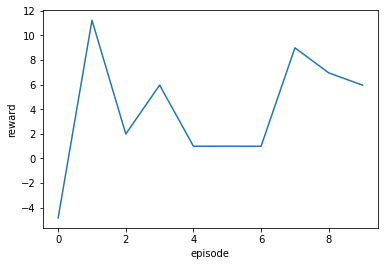

validate data reward


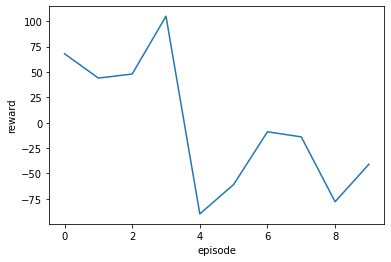

s shape (1, 4)
estimated shape (3,)
s shape (1, 4)
estimated shape (3,)
s shape (1, 4)
estimated shape (3,)
s shape (1, 4)
estimated shape (3,)
s shape (1, 4)
estimated shape (3,)
s shape (1, 4)
estimated shape (3,)
s shape (1, 4)
estimated shape (3,)
s shape (1, 4)
estimated shape (3,)
s shape (1, 4)
estimated shape (3,)
s shape (1, 4)
estimated shape (3,)
s shape (1, 4)
estimated shape (3,)
s shape (1, 4)
estimated shape (3,)
s shape (1, 4)
estimated shape (3,)
s shape (1, 4)
estimated shape (3,)
s shape (1, 4)
estimated shape (3,)
s shape (1, 4)
estimated shape (3,)
s shape (1, 4)
estimated shape (3,)
s shape (1, 4)
estimated shape (3,)
s shape (1, 4)
estimated shape (3,)
s shape (1, 4)
estimated shape (3,)
s shape (1, 4)
estimated shape (3,)
s shape (1, 4)
estimated shape (3,)
s shape (1, 4)
estimated shape (3,)
s shape (1, 4)
estimated shape (3,)
s shape (1, 4)
estimated shape (3,)
s shape (1, 4)
estimated shape (3,)
s shape (1, 4)
estimated shape (3,)
s shape (1, 4)
estimated sha

<Figure size 432x288 with 0 Axes>

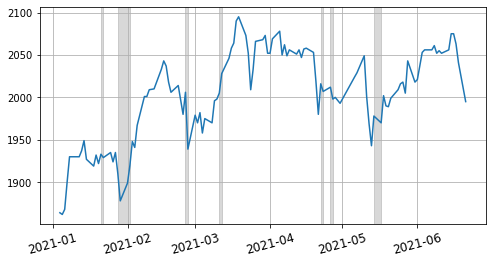

In [61]:
lq = LearnQN(path_tpx,path_daw)

# lq.show_chart()

episode_count=10
state='change_rate'
env_types = ['tanh']
for env_type in env_types:
    print("env type :",env_type)
    lq.learn_xqn(state=state,env_type=env_type,episode_count=episode_count,train_year=2020,test_year=2021)


# Preict tomorrow

today : 2021-12-16 00:00:00
episode : 0
Get reward 76.0.
Trade count 3.
Tomorrow action : Action.SELL


<Figure size 432x288 with 0 Axes>

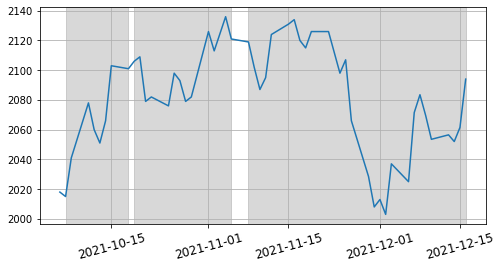

In [29]:
predict_tomorrow(lq_copy,folder_name='TOPIX')

# save model

In [5]:
save_path =  '/Users/rince/Desktop/Sotsuron/code/model/RL/Qagent/'
# lq.save(save_path)

# load model

---------------------
AUC train: 0.860577203982112
AUC test : 0.6767285722020684
              precision    recall  f1-score   support

           0       0.60      0.60      0.60       219
           1       0.65      0.65      0.65       253

    accuracy                           0.63       472
   macro avg       0.63      0.63      0.63       472
weighted avg       0.63      0.63      0.63       472



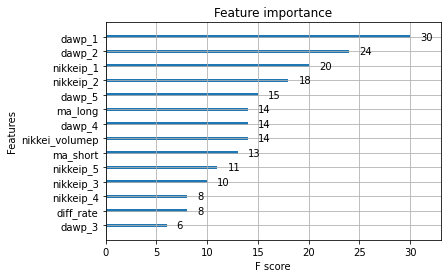

In [6]:
lq_copy = LearnQN.load(save_path+'xqn_change_rate_tanh_20211019.pickle')

In [54]:
import keras

In [99]:
Pipeline([("scaler", scaler), ("estimator", estimator)])

NameError: name 'scaler' is not defined

In [14]:
df_tpx = DataFramePreProcessing(path_tpx).load_df()

In [15]:
df_tpx.values.shape[0]
y_ = np.array(df_tpx.values.shape[0] * [1])

In [17]:
y_ = np.random.random(df_tpx.values.shape[0])

In [19]:
x_ = df_tpx.values


In [20]:
x_ = preprocessing

array([[8.49000e+02, 8.55000e+02, 8.48000e+02, 8.51000e+02, 1.14946e+06],
       [8.52000e+02, 8.60000e+02, 8.52000e+02, 8.59000e+02, 1.52715e+06],
       [8.57000e+02, 8.57000e+02, 8.49000e+02, 8.52000e+02, 6.78340e+06],
       ...,
       [2.06300e+03, 2.06300e+03, 2.04100e+03, 2.04100e+03, 8.74270e+05],
       [2.00400e+03, 2.00800e+03, 1.98300e+03, 1.99500e+03, 4.39402e+06],
       [2.04200e+03, 2.05800e+03, 2.03500e+03, 2.05600e+03, 2.79637e+06]])

おそらく, 連続でfit呼び出すとパラメタ保持した状態で, 更新される

In [21]:
out_put_size = 4
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(8, input_shape=(df_tpx.values.shape[1],)))
model.add(tf.keras.layers.Dense(out_put_size))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model.fit(x_, y_, batch_size=32, epochs=10)

Epoch 1/10
77/77 [==============================] - 1s 737us/step - loss: 1057577378002.0513 - accuracy: 0.0000e+00
Epoch 2/10
77/77 [==============================] - 0s 796us/step - loss: 149840422439.3846 - accuracy: 0.0000e+00
Epoch 3/10
77/77 [==============================] - 0s 953us/step - loss: 11294073074.8718 - accuracy: 0.0000e+00
Epoch 4/10
77/77 [==============================] - 0s 1ms/step - loss: 290710504.2051 - accuracy: 0.0000e+00
Epoch 5/10
77/77 [==============================] - 0s 960us/step - loss: 3579864.7612 - accuracy: 0.0000e+00
Epoch 6/10
77/77 [==============================] - 0s 856us/step - loss: 570287.9091 - accuracy: 0.0000e+00
Epoch 7/10
77/77 [==============================] - 0s 862us/step - loss: 565204.5689 - accuracy: 0.0000e+00
Epoch 8/10
77/77 [==============================] - 0s 877us/step - loss: 611871.0264 - accuracy: 0.0000e+00
Epoch 9/10
77/77 [==============================] - 0s 836us/step - loss: 568008.8261 - accuracy: 0.0000e+00

In [22]:
model.fit(x_, y_, batch_size=32, epochs=10)

Epoch 1/10
77/77 [==============================] - 0s 718us/step - loss: 575954.3750 - accuracy: 0.0000e+00
Epoch 2/10
77/77 [==============================] - 0s 562us/step - loss: 590519.1875 - accuracy: 0.0000e+00
Epoch 3/10
77/77 [==============================] - 0s 513us/step - loss: 577863.2500 - accuracy: 0.0000e+00
Epoch 4/10
77/77 [==============================] - 0s 513us/step - loss: 586840.8750 - accuracy: 0.0000e+00
Epoch 5/10
77/77 [==============================] - 0s 583us/step - loss: 599000.8750 - accuracy: 0.0000e+00
Epoch 6/10
77/77 [==============================] - 0s 951us/step - loss: 568998.3125 - accuracy: 0.0000e+00
Epoch 7/10
77/77 [==============================] - 0s 796us/step - loss: 566115.4375 - accuracy: 0.0000e+00
Epoch 8/10
77/77 [==============================] - 0s 738us/step - loss: 567507.8125 - accuracy: 0.0000e+00
Epoch 9/10
77/77 [==============================] - 0s 853us/step - loss: 579578.6875 - accuracy: 0.0000e+00
Epoch 10/10
77/77 [

In [23]:
score = model.evaluate(x_,y_,batch_size=32)
score

77/77 [==============================] - 0s 843us/step - loss: 594240.3125 - accuracy: 0.0000e+00


[594240.3125, 0.0]

In [50]:
x_[0].reshape(1,-1).shape

(1, 5)

In [62]:
preprocessing.scale(x_[0])

NameError: name 'preprocessing' is not defined

In [47]:
x_[0].T.shape

(5,)

In [53]:
model.predict(x_[0].reshape(1,-1))[0].shape

(4,)

In [ ]:
Signature:
model.evaluate(
    x=None,
    y=None,
    batch_size=None,
    verbose=1,
    sample_weight=None,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    return_dict=False,
    **kwargs,
)
Docstring:
Returns the loss value & metrics values for the model in test mode.

Computation is done in batches (see the `batch_size` arg.)

Args:
    x: Input data. It could be:
      - A Numpy array (or array-like), or a list of arrays
        (in case the model has multiple inputs).
      - A TensorFlow tensor, or a list of tensors
        (in case the model has multiple inputs).
      - A dict mapping input names to the corresponding array/tensors,
        if the model has named inputs.
      - A `tf.data` dataset. Should return a tuple
        of either `(inputs, targets)` or
        `(inputs, targets, sample_weights)`.
      - A generator or `keras.utils.Sequence` returning `(inputs, targets)`
        or `(inputs, targets, sample_weights)`.
      A more detailed description of unpacking behavior for iterator types
      (Dataset, generator, Sequence) is given in the `Unpacking behavior
      for iterator-like inputs` section of `Model.fit`.
    y: Target data. Like the input data `x`, it could be either Numpy
      array(s) or TensorFlow tensor(s). It should be consistent with `x`
      (you cannot have Numpy inputs and tensor targets, or inversely). If
      `x` is a dataset, generator or `keras.utils.Sequence` instance, `y`
      should not be specified (since targets will be obtained from the
      iterator/dataset).
    batch_size: Integer or `None`. Number of samples per batch of
      computation. If unspecified, `batch_size` will default to 32. Do not
      specify the `batch_size` if your data is in the form of a dataset,
      generators, or `keras.utils.Sequence` instances (since they generate
      batches).
    verbose: 0 or 1. Verbosity mode. 0 = silent, 1 = progress bar.
    sample_weight: Optional Numpy array of weights for the test samples,
      used for weighting the loss function. You can either pass a flat (1D)
      Numpy array with the same length as the input samples
        (1:1 mapping between weights and samples), or in the case of
          temporal data, you can pass a 2D array with shape `(samples,
          sequence_length)`, to apply a different weight to every timestep
          of every sample. This argument is not supported when `x` is a
          dataset, instead pass sample weights as the third element of `x`.
    steps: Integer or `None`. Total number of steps (batches of samples)
      before declaring the evaluation round finished. Ignored with the
      default value of `None`. If x is a `tf.data` dataset and `steps` is
      None, 'evaluate' will run until the dataset is exhausted. This
      argument is not supported with array inputs.
    callbacks: List of `keras.callbacks.Callback` instances. List of
      callbacks to apply during evaluation. See
      [callbacks](/api_docs/python/tf/keras/callbacks).
    max_queue_size: Integer. Used for generator or `keras.utils.Sequence`
      input only. Maximum size for the generator queue. If unspecified,
      `max_queue_size` will default to 10.
    workers: Integer. Used for generator or `keras.utils.Sequence` input
      only. Maximum number of processes to spin up when using process-based
      threading. If unspecified, `workers` will default to 1.
    use_multiprocessing: Boolean. Used for generator or
      `keras.utils.Sequence` input only. If `True`, use process-based
      threading. If unspecified, `use_multiprocessing` will default to
      `False`. Note that because this implementation relies on
      multiprocessing, you should not pass non-picklable arguments to the
      generator as they can't be passed easily to children processes.
    return_dict: If `True`, loss and metric results are returned as a dict,
      with each key being the name of the metric. If `False`, they are
      returned as a list.
    **kwargs: Unused at this time.

See the discussion of `Unpacking behavior for iterator-like inputs` for
`Model.fit`.

`Model.evaluate` is not yet supported with
`tf.distribute.experimental.ParameterServerStrategy`.

Returns:
    Scalar test loss (if the model has a single output and no metrics)
    or list of scalars (if the model has multiple outputs
    and/or metrics). The attribute `model.metrics_names` will give you
    the display labels for the scalar outputs.

Raises:
    RuntimeError: If `model.evaluate` is wrapped in `tf.function`.
    ValueError: in case of invalid arguments.
File:      /usr/local/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py
Type:      method

In [ ]:
model.compile
model.compile(
    optimizer='rmsprop',
    loss=None,
    metrics=None,
    loss_weights=None,
    weighted_metrics=None,
    run_eagerly=None,
    steps_per_execution=None,
    **kwargs,
)

In [ ]:
Init signature: keras.Sequential(*args, **kwargs)
Docstring:     
`Sequential` groups a linear stack of layers into a `tf.keras.Model`.

`Sequential` provides training and inference features on this model.

Examples:

>>> # Optionally, the first layer can receive an `input_shape` argument:
>>> model = tf.keras.Sequential()
>>> model.add(tf.keras.layers.Dense(8, input_shape=(16,)))
>>> # Afterwards, we do automatic shape inference:
>>> model.add(tf.keras.layers.Dense(4))

>>> # This is identical to the following:
>>> model = tf.keras.Sequential()
>>> model.add(tf.keras.Input(shape=(16,)))
>>> model.add(tf.keras.layers.Dense(8))

>>> # Note that you can also omit the `input_shape` argument.
>>> # In that case the model doesn't have any weights until the first call
>>> # to a training/evaluation method (since it isn't yet built):
>>> model = tf.keras.Sequential()
>>> model.add(tf.keras.layers.Dense(8))
>>> model.add(tf.keras.layers.Dense(4))
>>> # model.weights not created yet

>>> # Whereas if you specify the input shape, the model gets built
>>> # continuously as you are adding layers:
>>> model = tf.keras.Sequential()
>>> model.add(tf.keras.layers.Dense(8, input_shape=(16,)))
>>> model.add(tf.keras.layers.Dense(4))
>>> len(model.weights)
4

>>> # When using the delayed-build pattern (no input shape specified), you can
>>> # choose to manually build your model by calling
>>> # `build(batch_input_shape)`:
>>> model = tf.keras.Sequential()
>>> model.add(tf.keras.layers.Dense(8))
>>> model.add(tf.keras.layers.Dense(4))
>>> model.build((None, 16))
>>> len(model.weights)
4

```python
# Note that when using the delayed-build pattern (no input shape specified),
# the model gets built the first time you call `fit`, `eval`, or `predict`,
# or the first time you call the model on some input data.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(8))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='sgd', loss='mse')
# This builds the model for the first time:
model.fit(x, y, batch_size=32, epochs=10)
```
Init docstring:
Creates a `Sequential` model instance.

Args:
  layers: Optional list of layers to add to the model.
  name: Optional name for the model.
File:           /usr/local/lib/python3.9/site-packages/keras/engine/sequential.py
Type:           type
Subclasses:     